In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from torch.utils.data import TensorDataset, DataLoader

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using device: cpu
PyTorch version: 2.8.0+cu126
CUDA available: False


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM Parameters
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.zeros(4 * hidden_size))

        # (Optional) Batch normalization – keep or remove
        self.bn_ih = nn.BatchNorm1d(4 * hidden_size)
        self.bn_hh = nn.BatchNorm1d(4 * hidden_size)
        self.bn_c = nn.BatchNorm1d(hidden_size)

    def forward(self, input, hx):
        h_prev, c_prev = hx
        batch_size = input.size(0)

        ih = F.linear(input, self.weight_ih, self.bias_ih)
        hh = F.linear(h_prev, self.weight_hh, self.bias_hh)

        if batch_size > 1:
            ih = self.bn_ih(ih)
            hh = self.bn_hh(hh)

        gates = ih + hh
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        # Standard activations
        forgetgate = torch.sigmoid(forgetgate)
        ingate = torch.sigmoid(ingate)
        cellgate_candidate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        c_next = forgetgate * c_prev + ingate * cellgate_candidate

        if batch_size > 1:
            c_next = self.bn_c(c_next)

        h_next = outgate * torch.tanh(c_next)

        return h_next, (h_next, c_next)

In [14]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = BaselineLSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, inputs, hx=None):
        # Input: [batch_size, seq_len, features]
        inputs = inputs.transpose(0, 1)  # → [seq_len, batch_size, features]

        if hx is None:
            batch_size = inputs.size(1)
            h_0 = torch.zeros(batch_size, self.cell.hidden_size, device=inputs.device)
            c_0 = torch.zeros(batch_size, self.cell.hidden_size, device=inputs.device)
            hx = (h_0, c_0)

        h, c = hx
        outputs = []

        for t in range(inputs.size(0)):
            h, (h, c) = self.cell(inputs[t], (h, c))
            outputs.append(h)

        outputs = torch.stack(outputs)
        outputs = outputs.transpose(0, 1)  # → back to [batch_size, seq_len, hidden]
        return outputs, (h, c)


In [15]:
class BaselineMultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super().__init__()
        self.lstm = BaselineLSTM(input_size, hidden_size)
        self.dropout = nn.Dropout(0.2)          # regularization
        self.bn = nn.BatchNorm1d(hidden_size)   # normalization
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_len, features]
        lstm_out, _ = self.lstm(x)

        # Use only the last time step
        last_output = lstm_out[:, -1, :]

        if last_output.size(0) > 1:  # BatchNorm only for batch > 1
            last_output = self.bn(last_output)

        last_output = self.dropout(last_output)
        predictions = self.linear(last_output)
        return predictions


In [16]:
def create_multivariate_sequences(data, seq_length, feature_column_idx=None, target_column_idx=None):
    """
    Create input/output sequences from multivariate time series data.

    Parameters:
    - data: numpy array of shape (samples, features)
    - seq_length: number of time steps to look back
    - feature_column_idx: index or list of indices of features to use for prediction
    - target_column_idx: which feature to predict

    Returns:
    - X: input sequences
    - y: target values
    """
    xs, ys = [], []

    # Ensure feature_column_idx is a list
    if feature_column_idx is not None and not isinstance(feature_column_idx, list):
        feature_column_idx = [feature_column_idx]

    for i in range(len(data) - seq_length):
        if feature_column_idx is not None:
            x = data[i:i+seq_length, feature_column_idx]
        else:
            x = data[i:i+seq_length]

        if target_column_idx is not None:
            y = data[i+seq_length, target_column_idx:target_column_idx+1]
        else:
            y = data[i+seq_length]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


def prepare_multivariate_data(data, seq_length=20, train_ratio=0.8, batch_size=32,
                             feature_column_idx=None, target_column_idx=None):
    """
    Prepare multivariate time series data for baseline LSTM training.

    Parameters:
    - data: pandas DataFrame or numpy array with multiple columns
    - seq_length: number of time steps to look back
    - train_ratio: proportion of data to use for training
    - batch_size: batch size for training
    - feature_column_idx: index or list of indices of features to use for prediction
    - target_column_idx: which feature to predict

    Returns:
    - Dictionary with data loaders, scalers, and other information
    """
    # Convert to numpy if DataFrame
    if isinstance(data, pd.DataFrame):
        column_names = data.columns
        data = data.values
    else:
        column_names = [f"Feature_{i}" for i in range(data.shape[1])]

    n_samples, n_features = data.shape
    print(f"Data shape: {n_samples} samples, {n_features} features")

    # Output size
    output_size = 1 if target_column_idx is not None else n_features

    # Input size
    if feature_column_idx is not None:
        input_size = len(feature_column_idx) if isinstance(feature_column_idx, list) else 1
    else:
        input_size = n_features

    print(f"Using {input_size} input feature(s) to predict {output_size} output(s)")

    # Split train/test
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]

    # ✅ Use [-1, 1] scaling for baseline LSTM (tanh-friendly)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)

    data_scaled = scaler.transform(data)

    # Build sequences
    X, y = create_multivariate_sequences(data_scaled, seq_length, feature_column_idx, target_column_idx)

    # Train/test split
    X_train, X_test = X[:train_size-seq_length], X[train_size-seq_length:]
    y_train, y_test = y[:train_size-seq_length], y[train_size-seq_length:]

    print(f"Created {len(X)} sequences with length {seq_length}")
    print(f"Training set: {len(X_train)} sequences, Test set: {len(X_test)} sequences")
    print(f"Input shape: {X.shape}, Output shape: {y.shape}")

    # Tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'test_loader': test_loader,
        'scaler': scaler,
        'data': data,
        'scaled_data': data_scaled,
        'train_size': train_size,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'seq_length': seq_length,
        'column_names': column_names,
        'output_size': output_size,
        'input_size': input_size,
        'feature_column_idx': feature_column_idx,
        'target_column_idx': target_column_idx
    }


In [17]:
def train_baseline_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001, use_logcosh=False):
    model = model.to(device)

    # Loss: choose between MSE and LogCosh
    criterion = LogCoshLoss() if use_logcosh else nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    train_losses = []
    test_losses = []

    print(f"Starting baseline training for {epochs} epochs on {device}...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # --- Evaluation ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                y_pred = model(X_test)
                test_loss += criterion(y_pred, y_test).item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        # LR scheduling
        scheduler.step(test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print("Baseline training completed.")
    return train_losses, test_losses


In [18]:
def predict_all_data(model, data_dict):
    """
    Make predictions on training and testing data
    and return both scaled and inverse-transformed results.
    """
    model.eval()
    scaler = data_dict['scaler']

    with torch.no_grad():
        # Predictions (scaled)
        train_predictions_scaled = model(data_dict['X_train']).cpu().numpy()
        test_predictions_scaled = model(data_dict['X_test']).cpu().numpy()

    # Actual values (scaled)
    train_actual_scaled = data_dict['y_train'].cpu().numpy()
    test_actual_scaled = data_dict['y_test'].cpu().numpy()

    # Inverse transform
    if data_dict['target_column_idx'] is not None:
        target_idx = data_dict['target_column_idx']

        # Build dummy arrays for inverse scaling
        def build_dummy(base_scaled, values_scaled):
            dummy = np.zeros((values_scaled.shape[0], scaler.scale_.shape[0]))
            dummy[:, target_idx:target_idx+1] = values_scaled
            return scaler.inverse_transform(dummy)[:, target_idx:target_idx+1]

        train_predictions = build_dummy(train_actual_scaled, train_predictions_scaled)
        test_predictions = build_dummy(test_actual_scaled, test_predictions_scaled)
        train_actual = build_dummy(train_actual_scaled, train_actual_scaled)
        test_actual = build_dummy(test_actual_scaled, test_actual_scaled)

    else:
        # If predicting all variables
        train_predictions = scaler.inverse_transform(train_predictions_scaled)
        test_predictions = scaler.inverse_transform(test_predictions_scaled)
        train_actual = scaler.inverse_transform(train_actual_scaled)
        test_actual = scaler.inverse_transform(test_actual_scaled)

    return {
        'train_predictions': train_predictions,
        'train_actual': train_actual,
        'test_predictions': test_predictions,
        'test_actual': test_actual,
        'train_predictions_scaled': train_predictions_scaled,
        'train_actual_scaled': train_actual_scaled,
        'test_predictions_scaled': test_predictions_scaled,
        'test_actual_scaled': test_actual_scaled
    }


In [19]:
def predict_and_visualize_multivariate_baseline(model, data_dict, title='Multivariate Time Series Forecasting'):
    """
    Visualization for multivariate time series predictions (baseline version).
    """
    # Get predictions
    predictions = predict_all_data(model, data_dict)

    # Determine if we're predicting single or multiple targets
    is_single_target = data_dict['target_column_idx'] is not None
    target_idx = data_dict['target_column_idx'] if is_single_target else None

    # Get target names
    if is_single_target:
        target_name = data_dict['column_names'][target_idx]
        target_names = [target_name]
    else:
        target_names = data_dict['column_names']

    # Metrics storage
    train_rmse_values, test_rmse_values = [], []
    train_rmse_scaled_values, test_rmse_scaled_values = [], []

    # Sequence indices for plotting
    seq_length = data_dict['seq_length']
    train_indices = np.arange(seq_length, seq_length + predictions['train_actual'].shape[0])
    test_indices = np.arange(
        seq_length + predictions['train_actual'].shape[0],
        seq_length + predictions['train_actual'].shape[0] + predictions['test_actual'].shape[0]
    )

    # Process each target variable
    for i in range(len(target_names)):
        if is_single_target:
            train_actual_i = predictions['train_actual']
            train_pred_i = predictions['train_predictions']
            test_actual_i = predictions['test_actual']
            test_pred_i = predictions['test_predictions']
            train_actual_scaled_i = predictions['train_actual_scaled']
            train_pred_scaled_i = predictions['train_predictions_scaled']
            test_actual_scaled_i = predictions['test_actual_scaled']
            test_pred_scaled_i = predictions['test_predictions_scaled']
        else:
            train_actual_i = predictions['train_actual'][:, i:i+1]
            train_pred_i = predictions['train_predictions'][:, i:i+1]
            test_actual_i = predictions['test_actual'][:, i:i+1]
            test_pred_i = predictions['test_predictions'][:, i:i+1]
            train_actual_scaled_i = predictions['train_actual_scaled'][:, i:i+1]
            train_pred_scaled_i = predictions['train_predictions_scaled'][:, i:i+1]
            test_actual_scaled_i = predictions['test_actual_scaled'][:, i:i+1]
            test_pred_scaled_i = predictions['test_predictions_scaled'][:, i:i+1]

        # RMSE
        train_rmse = sqrt(mean_squared_error(train_actual_i, train_pred_i))
        test_rmse = sqrt(mean_squared_error(test_actual_i, test_pred_i))
        train_rmse_scaled = sqrt(mean_squared_error(train_actual_scaled_i, train_pred_scaled_i))
        test_rmse_scaled = sqrt(mean_squared_error(test_actual_scaled_i, test_pred_scaled_i))

        train_rmse_values.append(train_rmse)
        test_rmse_values.append(test_rmse)
        train_rmse_scaled_values.append(train_rmse_scaled)
        test_rmse_scaled_values.append(test_rmse_scaled)

        # Plots (same as before, no changes)
        if is_single_target or (len(target_names) <= 3):
            plt.figure(figsize=(15, 8))
            if is_single_target:
                original_data = data_dict['data'][:, target_idx]
                plt.plot(np.arange(len(original_data)), original_data,
                        label='Original Data', color='lightgray', alpha=0.7)

            plt.plot(train_indices, train_actual_i, label='Training Actual', color='blue', alpha=0.5)
            plt.plot(train_indices, train_pred_i, label='Training Predictions', color='green', alpha=0.7)
            plt.plot(test_indices, test_actual_i, label='Test Actual', color='darkblue')
            plt.plot(test_indices, test_pred_i, label='Test Predictions', color='red')

            plt.axvspan(min(train_indices), max(train_indices), color='lightblue', alpha=0.2, label='Training Region')
            plt.axvspan(min(test_indices), max(test_indices), color='lightpink', alpha=0.2, label='Testing Region')

            plt.title(f'{title} - {target_names[i]}')
            plt.xlabel('Time Steps')
            plt.ylabel('Value')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Zoomed-in training
            plt.figure(figsize=(15, 6))
            plt.plot(train_actual_i, label=f'Training Actual - {target_names[i]}', color='blue')
            plt.plot(train_pred_i, label=f'Training Predictions - {target_names[i]}', color='green')
            plt.title(f'Training Data Predictions - {target_names[i]} - RMSE: {train_rmse:.4f}')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Zoomed-in testing
            plt.figure(figsize=(15, 6))
            plt.plot(test_actual_i, label=f'Test Actual - {target_names[i]}', color='darkblue')
            plt.plot(test_pred_i, label=f'Test Predictions - {target_names[i]}', color='red')
            plt.title(f'Test Data Predictions - {target_names[i]} - RMSE: {test_rmse:.4f}')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Scatter plots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            ax1.scatter(train_actual_i, train_pred_i, alpha=0.5, color='green')
            min_val, max_val = train_actual_i.min(), train_actual_i.max()
            ax1.plot([min_val, max_val], [min_val, max_val], 'r--')
            ax1.set_title(f'Training: Actual vs Predicted - {target_names[i]}')

            ax2.scatter(test_actual_i, test_pred_i, alpha=0.5, color='red')
            min_val, max_val = test_actual_i.min(), test_actual_i.max()
            ax2.plot([min_val, max_val], [min_val, max_val], 'r--')
            ax2.set_title(f'Testing: Actual vs Predicted - {target_names[i]}')

            plt.tight_layout()
            plt.show()

    # Print summary
    for i, target_name in enumerate(target_names):
        print(f"\nMetrics for {target_name}:")
        print(f"Training RMSE: {train_rmse_values[i]:.4f}")
        print(f"Test RMSE: {test_rmse_values[i]:.4f}")
        print(f"Training RMSE (Scaled): {train_rmse_scaled_values[i]:.4f}")
        print(f"Test RMSE (Scaled): {test_rmse_scaled_values[i]:.4f}")

    if len(target_names) > 1:
        print("\nAverage Metrics Across All Targets:")
        print(f"Avg Training RMSE: {np.mean(train_rmse_values):.4f}")
        print(f"Avg Test RMSE: {np.mean(test_rmse_values):.4f}")

    return {
        'train_rmse': train_rmse_values,
        'test_rmse': test_rmse_values,
        'train_rmse_scaled': train_rmse_scaled_values,
        'test_rmse_scaled': test_rmse_scaled_values,
        'predictions': predictions
    }


In [20]:
def load_multivariate_from_csv(csv_path, feature_columns=None, date_column=None):
    """
    Load multivariate time series data from a CSV file.

    Parameters:
    - csv_path: path to the CSV file
    - feature_columns: list of column names to use as features (None = use all numeric columns)
    - date_column: name of the date column (optional)

    Returns:
    - DataFrame containing the selected features
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    print(f"CSV loaded successfully. Columns: {', '.join(df.columns)}")

    # Convert date column to datetime if specified
    if date_column is not None and date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column])
        df = df.sort_values(by=date_column)
        print(f"Data sorted by {date_column}")

    # Select features
    if feature_columns is None:
        # Use all numeric columns if none specified
        feature_columns = df.select_dtypes(include=['number']).columns.tolist()
        # Remove date column if it was included
        if date_column in feature_columns:
            feature_columns.remove(date_column)
    else:
        # Verify all requested columns exist
        missing_cols = [col for col in feature_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Columns not found in CSV: {missing_cols}")

    # Extract features
    features_df = df[feature_columns].copy()
    print(f"Selected {len(feature_columns)} features: {', '.join(feature_columns)}")

    # Check for missing values
    missing_values = features_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Found {missing_values} missing values. Filling with forward fill then backward fill.")
        features_df = features_df.fillna(method='ffill').fillna(method='bfill')

        # Check if there are still missing values
        remaining_missing = features_df.isnull().sum().sum()
        if remaining_missing > 0:
             # Check if there are still missing values
            remaining_missing = features_df.isnull().sum().sum()
        if remaining_missing > 0:
            print(f"Warning: {remaining_missing} missing values remain after filling.")
            print("Filling remaining missing values with column means.")
            features_df = features_df.fillna(features_df.mean())

    return features_df
def train_from_csv_baseline(csv_path, feature_column=None, target_column=None, date_column=None,
                            seq_length=20, hidden_size=50, epochs=100, batch_size=32,
                            learning_rate=0.001):
    """
    Complete pipeline for training the Baseline LSTM model from a CSV file.

    Parameters:
    - csv_path: path to the CSV file
    - feature_column: column to use as input feature (None = use all columns)
    - target_column: column to predict (None = use all columns)
    - date_column: date column for sorting data (optional)
    - seq_length: number of time steps to look back
    - hidden_size: size of LSTM hidden layer
    - epochs: number of training epochs
    - batch_size: batch size for training
    - learning_rate: initial learning rate

    Returns:
    - trained model, evaluation results, and training history
    """
    print(f"Loading data from {csv_path}...")

    # Load all data
    all_data = load_multivariate_from_csv(csv_path, feature_columns=None, date_column=date_column)

    # Init indices
    feature_column_idx = None
    target_column_idx = None

    # Handle feature column
    if feature_column is not None:
        if isinstance(feature_column, str):
            if feature_column not in all_data.columns:
                raise ValueError(f"Feature column '{feature_column}' not found in data")
            feature_column_idx = list(all_data.columns).index(feature_column)
            print(f"Feature column '{feature_column}' has index {feature_column_idx}")
        elif isinstance(feature_column, list):
            feature_indices = []
            for col in feature_column:
                if col not in all_data.columns:
                    raise ValueError(f"Feature column '{col}' not found in data")
                feature_indices.append(list(all_data.columns).index(col))
            feature_column_idx = feature_indices
            print(f"Feature columns {feature_column} have indices {feature_column_idx}")

    # Handle target column
    if target_column is not None:
        if target_column not in all_data.columns:
            raise ValueError(f"Target column '{target_column}' not found in data")
        target_column_idx = list(all_data.columns).index(target_column)
        print(f"Target column '{target_column}' has index {target_column_idx}")

    # Prepare data
    data_dict = prepare_multivariate_data(
        all_data,
        seq_length=seq_length,
        train_ratio=0.8,
        batch_size=batch_size,
        feature_column_idx=feature_column_idx,
        target_column_idx=target_column_idx
    )

    input_size = data_dict['input_size']
    output_size = data_dict['output_size']

    print(f"Creating Baseline LSTM with {input_size} input features, {hidden_size} hidden units, and {output_size} output(s)")
    model = BaselineMultivariateLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size
    )

    # Train
    train_losses, test_losses = train_baseline_model(
        model,
        data_dict['train_loader'],
        data_dict['test_loader'],
        epochs=epochs,
        learning_rate=learning_rate
    )

    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.yscale('log')
    plt.title('Loss Curves (Baseline LSTM)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate + visualize
    print("\nEvaluating baseline model and generating predictions...")

    if feature_column is not None and target_column is not None:
        feature_name = feature_column if isinstance(feature_column, str) else '+'.join(feature_column)
        title = f'Forecasting {target_column} using {feature_name}'
    elif target_column is not None:
        title = f'Forecasting {target_column} using all features'
    else:
        title = 'Multivariate Time Series Forecasting'

    results = predict_and_visualize_multivariate_baseline(
        model,
        data_dict,
        title=title
    )

    print(f"Training RMSE: {results['train_rmse'][0]:.4f}")
    print(f"Test RMSE: {results['test_rmse'][0]:.4f}")

    return model, results, (train_losses, test_losses), data_dict


Loading data from lorenz2.csv...
CSV loaded successfully. Columns: x, y, z
Selected 3 features: x, y, z
Feature columns ['y', 'z'] have indices [1, 2]
Target column 'x' has index 0
Data shape: 20000 samples, 3 features
Using 2 input feature(s) to predict 1 output(s)
Created 19940 sequences with length 60
Training set: 15940 sequences, Test set: 4000 sequences
Input shape: (19940, 60, 2), Output shape: (19940, 1)
Creating Baseline LSTM with 2 input features, 64 hidden units, and 1 output(s)
Starting baseline training for 5 epochs on cpu...
Epoch 1/5, Train Loss: 0.0602, Test Loss: 0.0443
Epoch 2/5, Train Loss: 0.0136, Test Loss: 0.0893
Epoch 3/5, Train Loss: 0.0123, Test Loss: 0.0406
Epoch 4/5, Train Loss: 0.0121, Test Loss: 0.0068
Epoch 5/5, Train Loss: 0.0121, Test Loss: 0.1434
Baseline training completed.


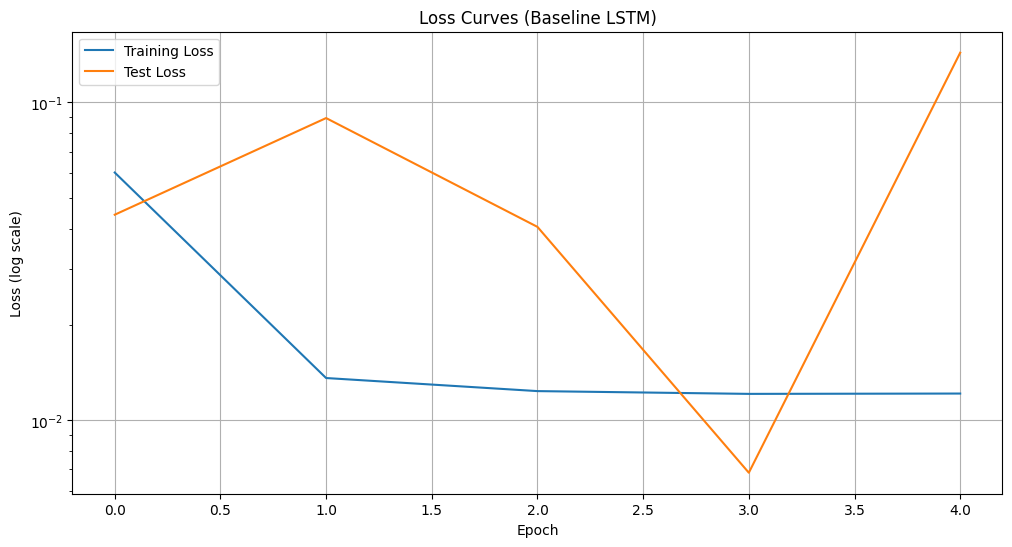


Evaluating baseline model and generating predictions...


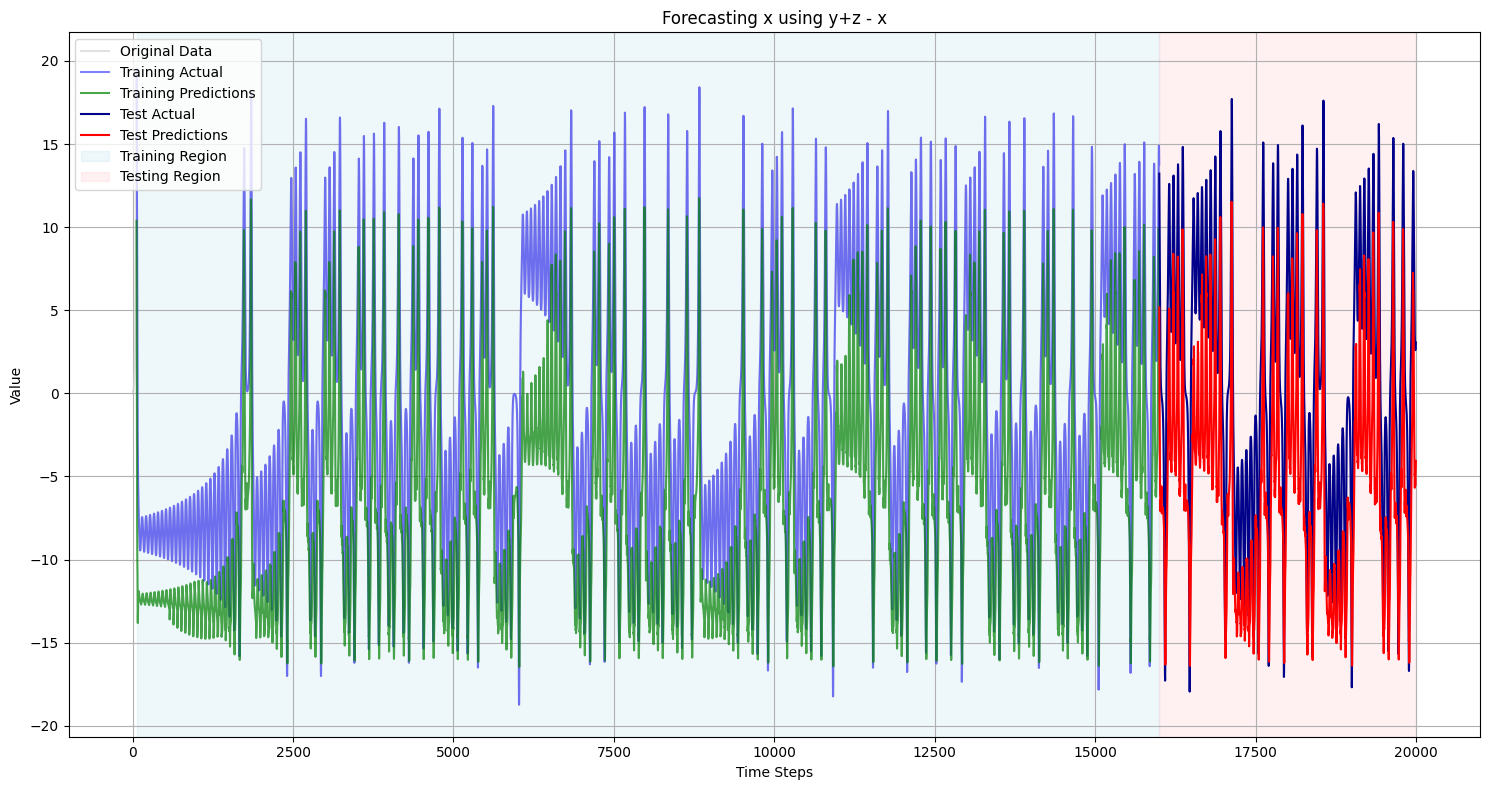

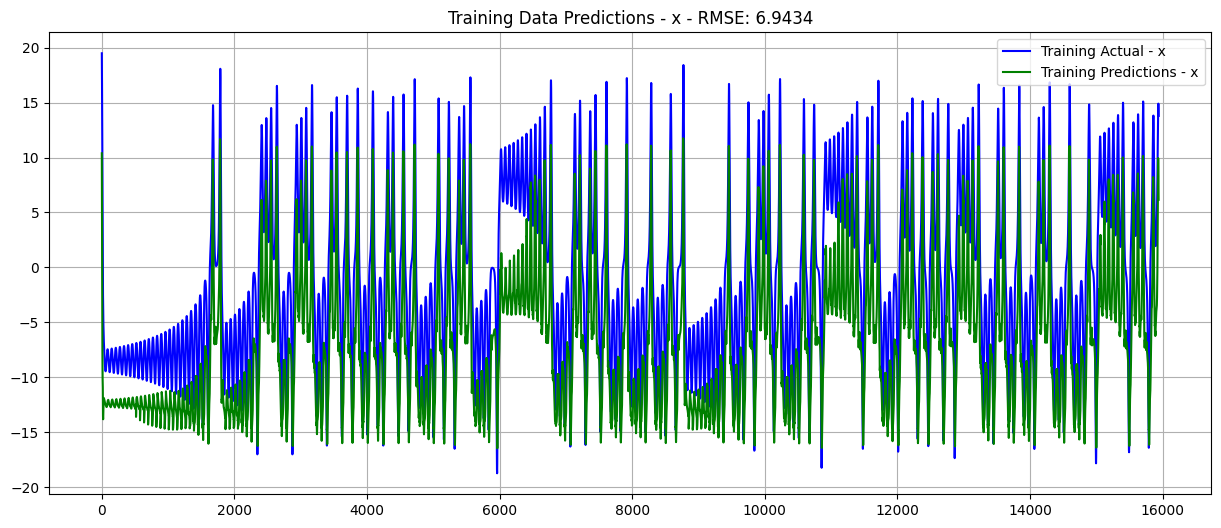

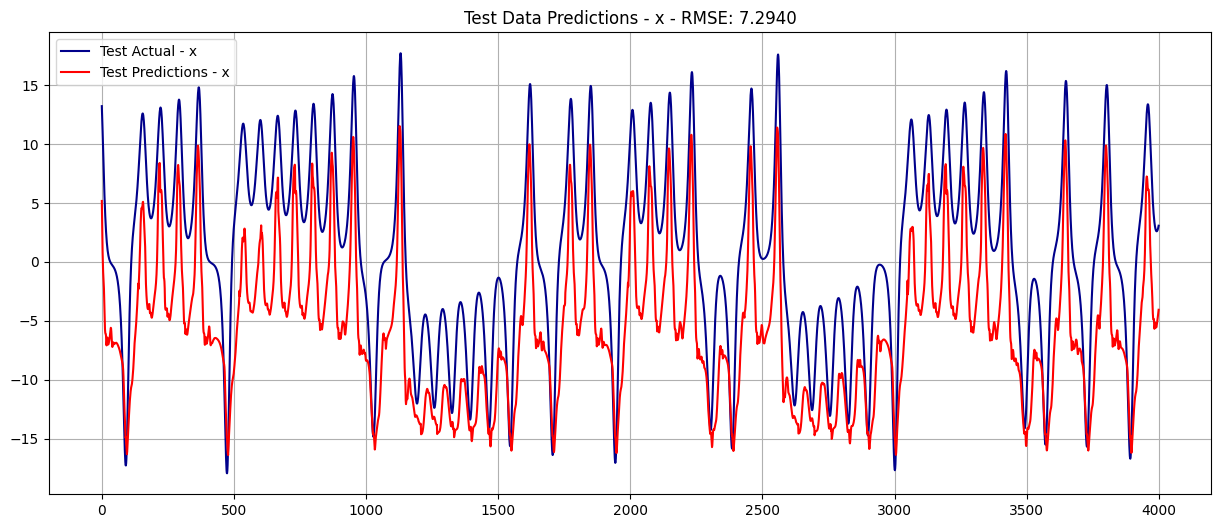

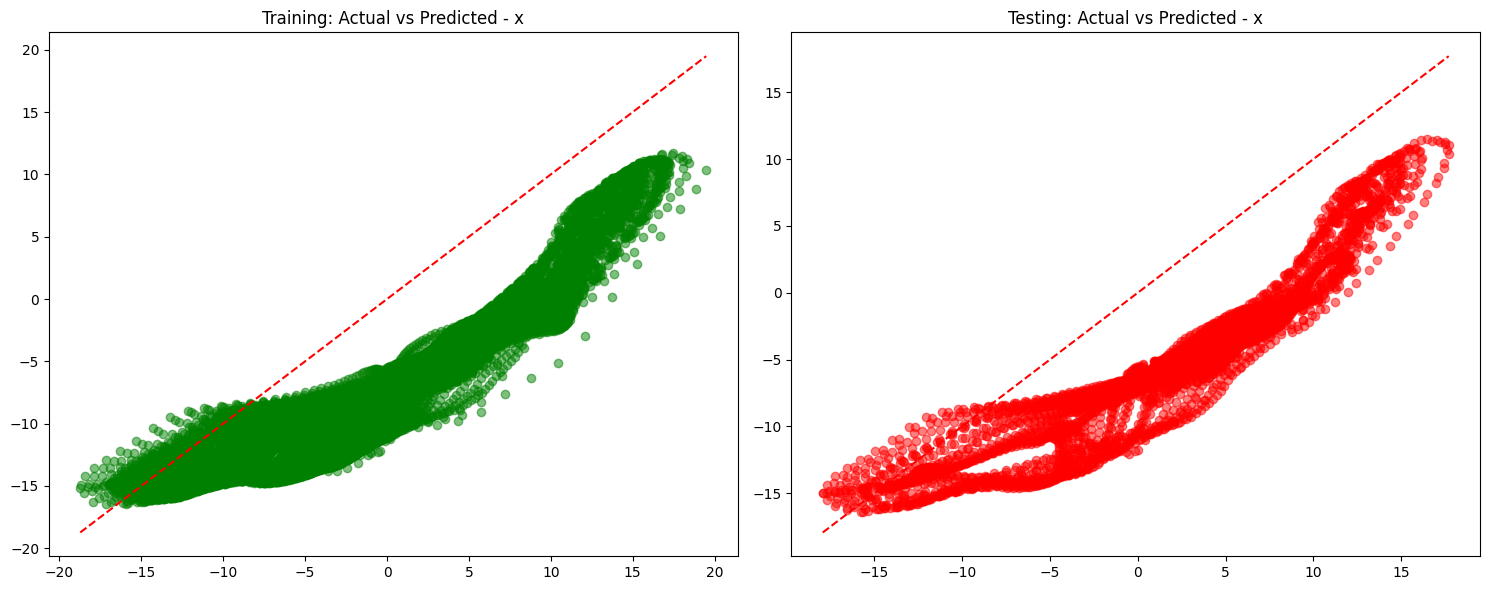


Metrics for x:
Training RMSE: 6.9434
Test RMSE: 7.2940
Training RMSE (Scaled): 0.3604
Test RMSE (Scaled): 0.3786
Training RMSE: 6.9434
Test RMSE: 7.2940
Training Results Summary (Baseline):
Final Training RMSE: 6.9434
Final Test RMSE: 7.2940


In [21]:
csv_path = 'lorenz2.csv'  # Update to your file path

# Train Baseline LSTM
model, results, history, data_dict = train_from_csv_baseline(
    csv_path,
    feature_column=['y', 'z'],  # Use multiple features
    target_column='x',          # Predict 'x'
    date_column='time',
    seq_length=60,
    hidden_size=64,
    epochs=5
)

print("Training Results Summary (Baseline):")
print(f"Final Training RMSE: {results['train_rmse'][0]:.4f}")
print(f"Final Test RMSE: {results['test_rmse'][0]:.4f}")


# from sklearn.feature_selection import mutual_info_regression

# def compute_mutual_information_baseline(model, data_loader, n_batches=10):
#     """
#     Compute MI between inputs and hidden states for Baseline LSTM.
#     """
#     from sklearn.decomposition import PCA
#     model.eval()
#     mi_values = []

#     with torch.no_grad():
#         for i, (X_batch, _) in enumerate(data_loader):
#             if i >= n_batches:
#                 break

#             X_batch = X_batch.to(next(model.parameters()).device)
#             lstm_out, _ = model.lstm(X_batch)   # [batch, seq_len, hidden]

#             X_np = X_batch.cpu().numpy().reshape(X_batch.shape[0], -1)
#             H_np = lstm_out.cpu().numpy().reshape(X_batch.shape[0], -1)

#             # PCA reduce inputs
#             pca = PCA(n_components=min(10, X_np.shape[1]))
#             X_reduced = pca.fit_transform(X_np)

#             # MI for each hidden unit
#             for j in range(H_np.shape[1]):
#                 y = H_np[:, j]
#                 mi = mutual_info_regression(X_reduced, y, discrete_features=False)
#                 mi_values.append(np.mean(mi))

#     return np.mean(mi_values)

# baseline_mi = compute_mutual_information_baseline(model, data_dict['train_loader'])
# print(f"Baseline MI: {baseline_mi:.4f}")


In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt


# ---- VAR (Multivariate) ----
def evaluate_var_baseline(data_dict, maxlags=5):
    """
    Fit VAR on all features and compute RMSE on the target variable.
    """
    data = pd.DataFrame(data_dict['data'], columns=data_dict['column_names'])
    train_size = data_dict['train_size']
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    model = VAR(train)
    model_fit = model.fit(maxlags=maxlags)
    forecast = model_fit.forecast(train.values, steps=len(test))
    forecast_df = pd.DataFrame(forecast, columns=data.columns)

    target_idx = data_dict['target_column_idx']
    target_name = data.columns[target_idx]

    rmse = sqrt(mean_squared_error(test[target_name], forecast_df[target_name]))
    print(f"[Baseline] VAR RMSE on target '{target_name}': {rmse:.4f}")

    return forecast_df[target_name].values, test[target_name].values, rmse
var_pred_base, var_actual_base, var_rmse_base = evaluate_var_baseline(data_dict, maxlags=5)




[Baseline] VAR RMSE on target 'x': 8.0018


Multi-step RMSE over 200 steps: 0.3868


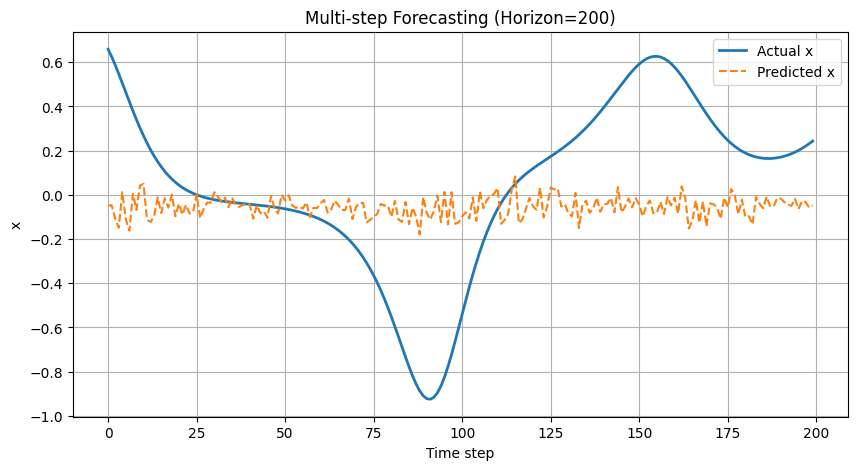

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def multi_step_forecast(model, data_dict, steps=100):
    """
    Roll out predictions for multiple steps to test chaotic forecasting horizon.
    Assumes inputs = [y, z], target = x.
    """
    model.eval()
    X_test = data_dict['X_test'][0:1].clone()  # shape [1, seq_len, num_features]
    preds = []

    with torch.no_grad():
        for i in range(steps):
            y_pred = model(X_test)  # [1, 1]
            preds.append(y_pred.cpu().numpy())

            # Shift: drop oldest timestep
            new_input = X_test[:, 1:, :].clone()

            # Append next features for y,z from ground truth
            feat_idx = data_dict['feature_column_idx']
            next_feats = data_dict['X_test'][i+1:i+2, -1:, :].clone()

            # Append back y,z (not x, since x is target only)
            new_input = torch.cat([new_input, next_feats], dim=1)
            X_test = new_input

    preds = np.array(preds).squeeze()
    actual = data_dict['y_test'][:steps].cpu().numpy().squeeze()
    rmse = np.sqrt(mean_squared_error(actual, preds))

    # ---- Print result ----
    print(f"Multi-step RMSE over {steps} steps: {rmse:.4f}")

    # ---- Plot actual vs predicted ----
    plt.figure(figsize=(10,5))
    plt.plot(actual, label="Actual x", linewidth=2)
    plt.plot(preds, label="Predicted x", linestyle="--")
    plt.title(f"Multi-step Forecasting (Horizon={steps})")
    plt.xlabel("Time step")
    plt.ylabel("x")
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds, actual, rmse
# Baseline multi-step forecast
preds_base, actual_base, rmse_multi_base = multi_step_forecast(model, data_dict, steps=200)

